<a href="https://colab.research.google.com/github/davidklhui/data-analysis/blob/main/Tensorflow_(1)_Neural_Network_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrate the use of Neural Network to solve Regression problem using Tensorflow

# Introduction

In data science and machine learning world, there are 2 popular open-source libraries to perform neural networks. One is Tensorflow, another one is PyTorch. Although PyTorch's popularity is raising in recent years especially for research industry, Tensorflow is still very common in the market because of its mature community and ease-of-use API.

Neural network popular capibilities are:
1. regression problem (e.g. estimate response)
2. classification problem (e.g. classify into groups)
3. sequential data (e.g. Time Series analysis, NLP)

In this notebook, we will demo how to use neural network to do regression problem.


# Procedures

1. Exploratory Data Analysis (EDA)
2. Data Preparation (Feature Engineering)
3. Model Building
4. Model Evaluation
5. Prediction

# Prerequisites


## Import related libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0


## Data Source

For this project, we will use the data from Kaggle:
[Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance)
Data is availiable to download from the author's github

https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv


In [2]:
# retrieve the data using pandas as a Data Frame

data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

# note that the charges is the response variable, and the rest are explanatory variables
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Exploratory Data Analysis

Please read another notebook **Regression Analysis (1) - Linear Regression.ipynb**

# Data Preparation

For nominal data, we will perform one-hot encoding to split the nominal data into set of dummy variables.

For numeric continuous data, in neural network common practice, we usually required to **normalize** all numeric predictors (i.e. ranging from 0 to 1).

Furthermore for splitting the dataset, in neural network, we often needed to split the dataset into 3 parts:
1. train dataset (used to train the model parameters)
2. validation dataset (used to monitor if the model starts to overfit)
3. test dataset (final stage to evaluate the model capability)

By practitioner experience, we should use different set of scaler to transform both train, validation, and test dataset, as using the same set of scaler will expose some "information" about the training set to the test set.

So in this section, we will first perform one-hot encoding to the data; then perform train-validation-test split; finally define and apply the transformation scaler to dataset individually

## Applying one-hot encoding to data

In [3]:
# first define the response y, and the predictors X

y = data[['charges']]
X = data.drop('charges', axis=1)

In [4]:
# applying one-hot encoding
# like another project for linear regression, we used "get_dummy" to produce dummy variables.
# This time we will use one-hot encoding to produce functionally the same things
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_columns = encoder.fit_transform(X[['sex', 'smoker', 'region']])
encoded_df = pd.DataFrame(encoded_columns)
encoded_df.columns = ['is_male', 'is_smoker', 'NW', 'SE', 'SW']   # for regions, both 0 => north east NE

X_encoded = pd.concat((X[['age', 'bmi', 'children']], encoded_df), axis=1)


# to verify if the encoding is correct
X.head(20), encoded_columns[:20], encoded_df

(    age     sex     bmi  children smoker     region
 0    19  female  27.900         0    yes  southwest
 1    18    male  33.770         1     no  southeast
 2    28    male  33.000         3     no  southeast
 3    33    male  22.705         0     no  northwest
 4    32    male  28.880         0     no  northwest
 5    31  female  25.740         0     no  southeast
 6    46  female  33.440         1     no  southeast
 7    37  female  27.740         3     no  northwest
 8    37    male  29.830         2     no  northeast
 9    60  female  25.840         0     no  northwest
 10   25    male  26.220         0     no  northeast
 11   62  female  26.290         0    yes  southeast
 12   23    male  34.400         0     no  southwest
 13   56  female  39.820         0     no  southeast
 14   27    male  42.130         0    yes  southeast
 15   19    male  24.600         1     no  southwest
 16   52  female  30.780         1     no  northeast
 17   23    male  23.845         0     no  nor

## Train-Validation-Test split

In [5]:
# use sklearn built-in method

from sklearn.model_selection import train_test_split

# just for reproducibility, random_state can be ignored
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=123)

X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=456)

X_train.head(), y_train.head()

(     age    bmi  children  is_male  is_smoker   NW   SE   SW
 300   36  27.55         3      1.0        0.0  0.0  0.0  0.0
 904   60  35.10         0      0.0        0.0  0.0  0.0  1.0
 670   30  31.57         3      1.0        0.0  0.0  1.0  0.0
 617   49  25.60         2      1.0        1.0  0.0  0.0  1.0
 373   26  32.90         2      1.0        1.0  0.0  0.0  1.0,
         charges
 300   6746.7425
 904  12644.5890
 670   4837.5823
 617  23306.5470
 373  36085.2190)

In [6]:
"Training dataset: %s, %s" % (X_train.shape, y_train.shape),  \
"Validation dataset: %s, %s" % (X_validation.shape, y_validation.shape),  \
"Test dataset: %s, %s" % (X_test.shape, y_test.shape)

('Training dataset: (936, 8), (936, 1)',
 'Validation dataset: (201, 8), (201, 1)',
 'Test dataset: (201, 8), (201, 1)')

## Fit MinMaxScaler

This part is used to perform normalization for the features. In practice, we will instantiate a MinMaxScaler and use the training data to fit the scaler (and transform as well). Then in later sections, use the same scaler to transform the validation dataset and test dataset (as well as predictions)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# Model Building & Evaluation

For regresion problem using Neural Network, the common model is simply the fully connected network.

In this section, we will build several models with different hyperparameters (i.e. the parameters that we use to adjust the model, e.g. number of neurons per layer; the depth of the model (i.e. number of hidden layers); activation function (the way how to transform the inputs to output); ...

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Model1: initial trial

1. 4 hidden layers (100->100->100->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse



In [9]:
model1 = Sequential()
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))

# the last layer must only contain 1 output
model1.add(Dense(1))

# use optimizer 'adam', with loss function = mse
model1.compile(optimizer='adam', loss='mse')

# define callback function to detech overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)  # is validation loss starts to increase => overfitting, this will wait for 3 step

model1.fit(X_train, y_train,
          validation_data=(X_validation, y_validation),
           batch_size=128,      # number of samples that will be propagated through the network
           epochs=1000,         # one complete pass of the entire training dataset through the learning algorithm
           callbacks=[early_stop])



Epoch 1/1000
8/8 [==============================] - 2s 57ms/step - loss: 323020576.0000 - val_loss: 291957472.0000
Epoch 2/1000
8/8 [==============================] - 0s 11ms/step - loss: 322992576.0000 - val_loss: 291919264.0000
Epoch 3/1000
8/8 [==============================] - 0s 10ms/step - loss: 322937408.0000 - val_loss: 291839584.0000
Epoch 4/1000
8/8 [==============================] - 0s 20ms/step - loss: 322823392.0000 - val_loss: 291672576.0000
Epoch 5/1000
8/8 [==============================] - 0s 23ms/step - loss: 322585536.0000 - val_loss: 291343968.0000
Epoch 6/1000
8/8 [==============================] - 0s 12ms/step - loss: 322143712.0000 - val_loss: 290735712.0000
Epoch 7/1000
8/8 [==============================] - 0s 17ms/step - loss: 321324736.0000 - val_loss: 289658976.0000
Epoch 8/1000
8/8 [==============================] - 0s 14ms/step - loss: 319907040.0000 - val_loss: 287852320.0000
Epoch 9/1000
8/8 [==============================] - 0s 12ms/step - loss: 3175879

In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               900       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21201 (82.82 KB)
Trainable params: 21201 (82.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

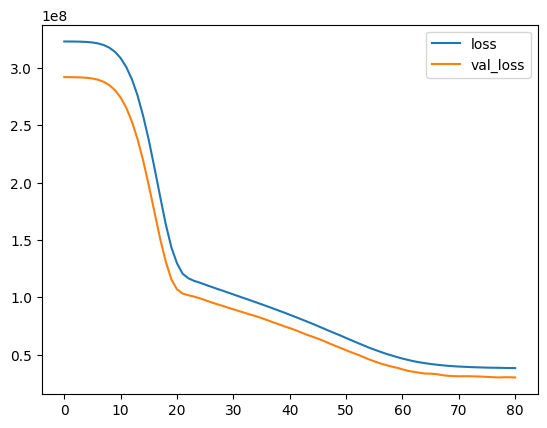

In [11]:
# see the loss history

history1 = pd.DataFrame(model1.history.history)
history1.plot()

7/7 [==============================] - 0s 7ms/step


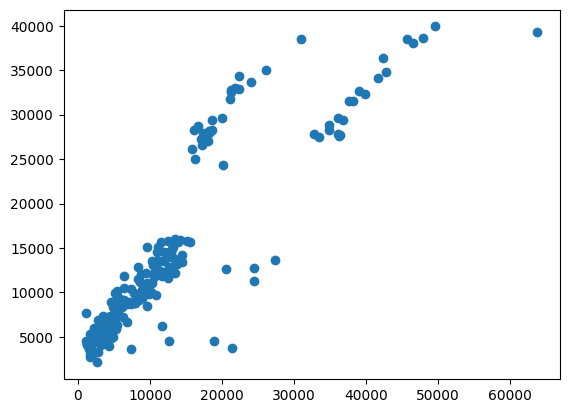

In [12]:
# see the performance on test dataset
from sklearn.metrics import mean_squared_error

prediction1 = model1.predict(X_validation)
plt.scatter(y_validation, prediction1)

In [13]:
mse1 = mean_squared_error(y_validation, prediction1)
print(mse1)


30190733.941510744


## Model2: more hidden layers under Model1

1. 4 hidden layers (100->100->100->100->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

In [14]:
# to prevent code replication, define a function by simply supplying the model, all remaining codes are the same

def model_fit(model, optimizer, batch_size):
  # use optimizer 'adam', with loss function = mse
  model.compile(optimizer=optimizer, loss='mse')
  model.fit(X_train, y_train,
            validation_data=(X_validation, y_validation),
            batch_size=batch_size,      # number of samples that will be propagated through the network
            epochs=10000,         # one complete pass of the entire training dataset through the learning algorithm
            callbacks=[early_stop])

  print('model summary: ', model.summary())
  history = pd.DataFrame(model.history.history)
  history.plot()
  plt.show()


  prediction = model.predict(X_validation)
  plt.scatter(y_validation, prediction)
  plt.show()

  # validation MSE
  mse = mean_squared_error(y_validation, prediction)
  print('mse: ', mse)

  return {'model': model, 'history': history, 'prediction': prediction, 'mse': mse}

Epoch 1/10000
8/8 [==============================] - 3s 120ms/step - loss: 323019520.0000 - val_loss: 291953504.0000
Epoch 2/10000
8/8 [==============================] - 0s 36ms/step - loss: 322982048.0000 - val_loss: 291892224.0000
Epoch 3/10000
8/8 [==============================] - 0s 41ms/step - loss: 322884640.0000 - val_loss: 291729024.0000
Epoch 4/10000
8/8 [==============================] - 0s 39ms/step - loss: 322620224.0000 - val_loss: 291304352.0000
Epoch 5/10000
8/8 [==============================] - 0s 32ms/step - loss: 321966592.0000 - val_loss: 290269024.0000
Epoch 6/10000
8/8 [==============================] - 0s 34ms/step - loss: 320415392.0000 - val_loss: 287915488.0000
Epoch 7/10000
8/8 [==============================] - 0s 27ms/step - loss: 317073504.0000 - val_loss: 282936768.0000
Epoch 8/10000
8/8 [==============================] - 0s 12ms/step - loss: 310084160.0000 - val_loss: 273230560.0000
Epoch 9/10000
8/8 [==============================] - 0s 14ms/step - los

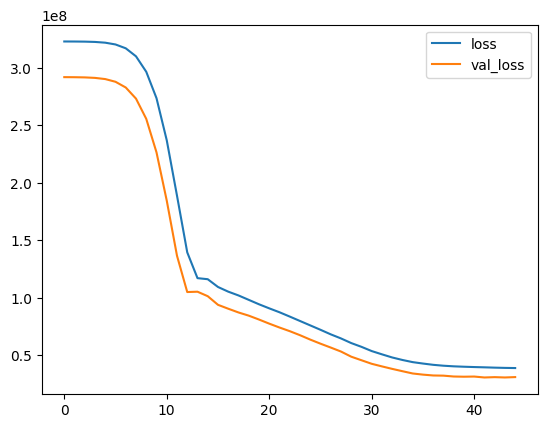

7/7 [==============================] - 0s 2ms/step


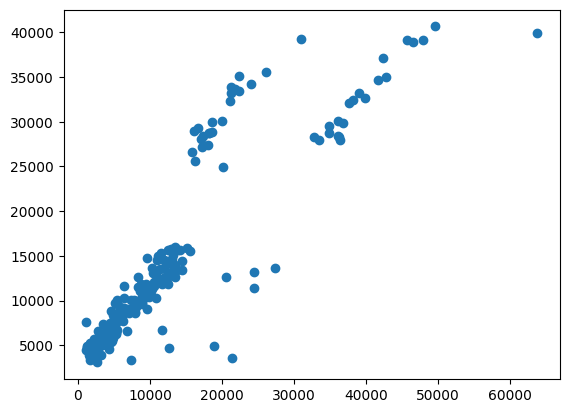

mse:  30687488.610939045


In [15]:
model2 = Sequential()
model2.add(Dense(100, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(1))

fit2 = model_fit(model2, optimizer='adam', batch_size=128)

In [16]:
mse2 = fit2['mse']

mse1, mse2


(30190733.941510744, 30687488.610939045)

mse2 is smaller than mse1, try to improve the model using Model2

## Model3: more neurals under Model2

1. 4 hidden layers (200->200->200->200->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse



Epoch 1/10000
8/8 [==============================] - 1s 28ms/step - loss: 323009888.0000 - val_loss: 291912384.0000
Epoch 2/10000
8/8 [==============================] - 0s 13ms/step - loss: 322855904.0000 - val_loss: 291562560.0000
Epoch 3/10000
8/8 [==============================] - 0s 11ms/step - loss: 322161248.0000 - val_loss: 290088480.0000
Epoch 4/10000
8/8 [==============================] - 0s 9ms/step - loss: 319475744.0000 - val_loss: 285154176.0000
Epoch 5/10000
8/8 [==============================] - 0s 12ms/step - loss: 311362624.0000 - val_loss: 271296864.0000
Epoch 6/10000
8/8 [==============================] - 0s 11ms/step - loss: 290158720.0000 - val_loss: 238454848.0000
Epoch 7/10000
8/8 [==============================] - 0s 11ms/step - loss: 244034624.0000 - val_loss: 177251344.0000
Epoch 8/10000
8/8 [==============================] - 0s 15ms/step - loss: 170522976.0000 - val_loss: 112606128.0000
Epoch 9/10000
8/8 [==============================] - 0s 16ms/step - loss:

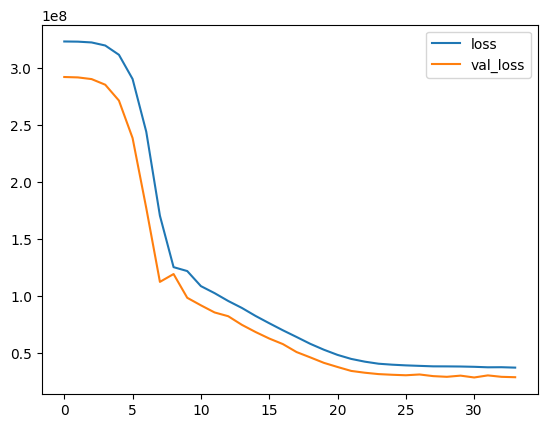

7/7 [==============================] - 0s 3ms/step


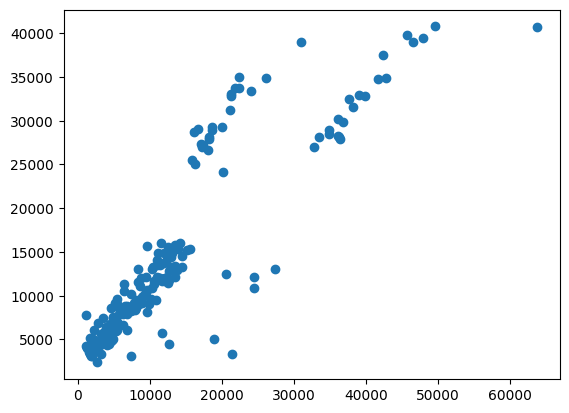

mse:  29156810.08226481


(30687488.610939045, 29156810.08226481)

In [17]:
model3 = Sequential()
model3.add(Dense(200, activation='relu'))
model3.add(Dense(200, activation='relu'))
model3.add(Dense(200, activation='relu'))
model3.add(Dense(200, activation='relu'))
model3.add(Dense(1))

fit3 = model_fit(model3, optimizer='adam', batch_size=128)

mse3 = fit3['mse']

mse2, mse3

Slight improvement in mse, adjust using Model3

## Model4: even more neurons under Model3

1. 4 hidden layers (250->250->250->250->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

Epoch 1/10000
8/8 [==============================] - 1s 37ms/step - loss: 322986720.0000 - val_loss: 291748384.0000
Epoch 2/10000
8/8 [==============================] - 0s 17ms/step - loss: 322218208.0000 - val_loss: 289615680.0000
Epoch 3/10000
8/8 [==============================] - 0s 18ms/step - loss: 317375840.0000 - val_loss: 278388160.0000
Epoch 4/10000
8/8 [==============================] - 0s 20ms/step - loss: 296104384.0000 - val_loss: 237080928.0000
Epoch 5/10000
8/8 [==============================] - 0s 17ms/step - loss: 230403312.0000 - val_loss: 141026128.0000
Epoch 6/10000
8/8 [==============================] - 0s 16ms/step - loss: 133139496.0000 - val_loss: 119100856.0000
Epoch 7/10000
8/8 [==============================] - 0s 16ms/step - loss: 121905736.0000 - val_loss: 89751024.0000
Epoch 8/10000
8/8 [==============================] - 0s 16ms/step - loss: 97397752.0000 - val_loss: 79829928.0000
Epoch 9/10000
8/8 [==============================] - 0s 18ms/step - loss: 8

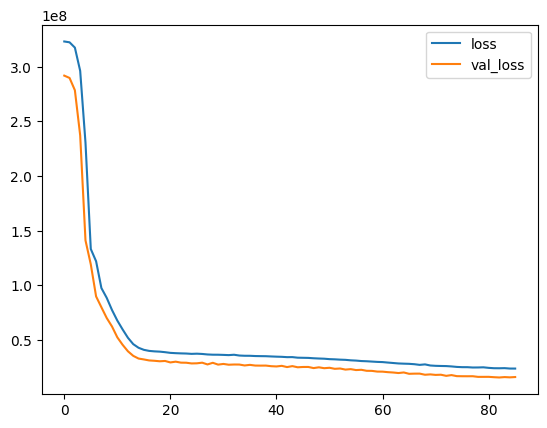

7/7 [==============================] - 0s 3ms/step


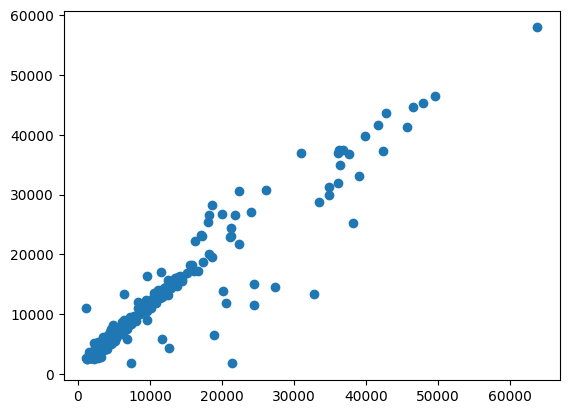

mse:  15998984.866318043


(29156810.08226481, 15998984.866318043)

In [18]:
model4 = Sequential()
model4.add(Dense(400, activation='relu'))
model4.add(Dense(400, activation='relu'))
model4.add(Dense(400, activation='relu'))
model4.add(Dense(400, activation='relu'))
model4.add(Dense(1))

fit4 = model_fit(model4, optimizer='adam', batch_size=128)

mse4 = fit4['mse']

mse3, mse4

Still improving in mse, next try more layer

## Model5: one more layer under Model4

1. 5 hidden layers (400->400->400->400->400->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

Epoch 1/10000
8/8 [==============================] - 1s 41ms/step - loss: 322965024.0000 - val_loss: 291568960.0000
Epoch 2/10000
8/8 [==============================] - 0s 20ms/step - loss: 321055040.0000 - val_loss: 284471424.0000
Epoch 3/10000
8/8 [==============================] - 0s 23ms/step - loss: 300722848.0000 - val_loss: 228883456.0000
Epoch 4/10000
8/8 [==============================] - 0s 21ms/step - loss: 196916864.0000 - val_loss: 106417976.0000
Epoch 5/10000
8/8 [==============================] - 0s 22ms/step - loss: 123841160.0000 - val_loss: 89020832.0000
Epoch 6/10000
8/8 [==============================] - 0s 19ms/step - loss: 96940488.0000 - val_loss: 73170792.0000
Epoch 7/10000
8/8 [==============================] - 0s 20ms/step - loss: 81346952.0000 - val_loss: 61373668.0000
Epoch 8/10000
8/8 [==============================] - 0s 18ms/step - loss: 64783884.0000 - val_loss: 47763084.0000
Epoch 9/10000
8/8 [==============================] - 0s 20ms/step - loss: 53780

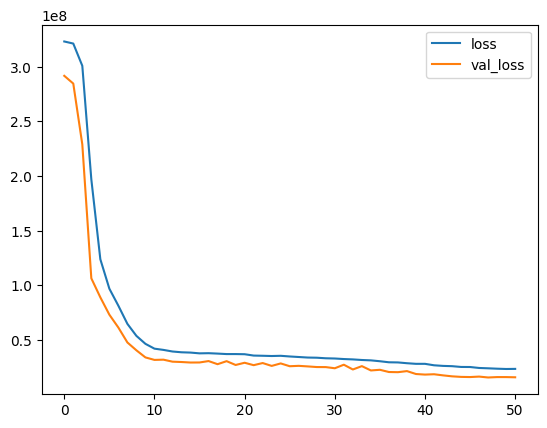

7/7 [==============================] - 0s 3ms/step


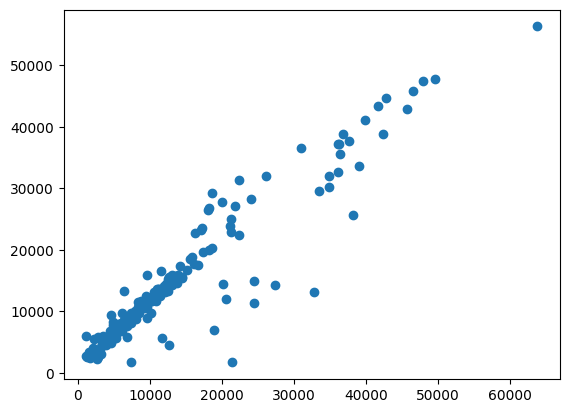

mse:  15925677.530781338


(15998984.866318043, 15925677.530781338)

In [19]:
model5 = Sequential()
model5.add(Dense(400, activation='relu'))
model5.add(Dense(400, activation='relu'))
model5.add(Dense(400, activation='relu'))
model5.add(Dense(400, activation='relu'))
model5.add(Dense(400, activation='relu'))
model5.add(Dense(1))

fit5 = model_fit(model5, optimizer='adam', batch_size=128)

mse5 = fit5['mse']

mse4, mse5

Still improving MSE

## Model6: one more layer under Model5

1. 6 hidden layers (400->400->400->400->400->400->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

Epoch 1/10000
8/8 [==============================] - 2s 46ms/step - loss: 322945664.0000 - val_loss: 291321408.0000
Epoch 2/10000
8/8 [==============================] - 0s 22ms/step - loss: 318679072.0000 - val_loss: 272383840.0000
Epoch 3/10000
8/8 [==============================] - 0s 22ms/step - loss: 255097152.0000 - val_loss: 114778704.0000
Epoch 4/10000
8/8 [==============================] - 0s 22ms/step - loss: 137287184.0000 - val_loss: 88211656.0000
Epoch 5/10000
8/8 [==============================] - 0s 23ms/step - loss: 108451912.0000 - val_loss: 77958832.0000
Epoch 6/10000
8/8 [==============================] - 0s 24ms/step - loss: 80720272.0000 - val_loss: 69072200.0000
Epoch 7/10000
8/8 [==============================] - 0s 22ms/step - loss: 65795972.0000 - val_loss: 47503944.0000
Epoch 8/10000
8/8 [==============================] - 0s 22ms/step - loss: 53667996.0000 - val_loss: 45726232.0000
Epoch 9/10000
8/8 [==============================] - 0s 23ms/step - loss: 473229

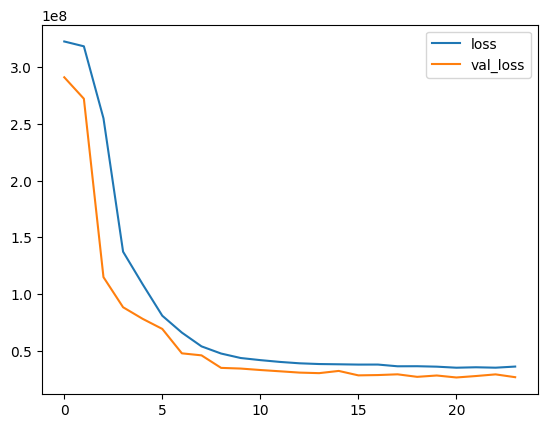

7/7 [==============================] - 0s 3ms/step


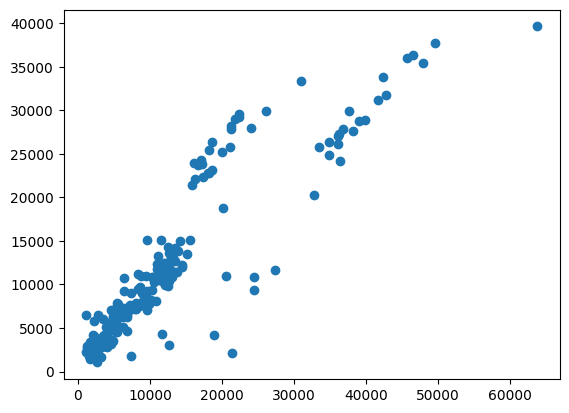

mse:  26437345.848849006


(15925677.530781338, 26437345.848849006)

In [20]:
model6 = Sequential()
model6.add(Dense(400, activation='relu'))
model6.add(Dense(400, activation='relu'))
model6.add(Dense(400, activation='relu'))
model6.add(Dense(400, activation='relu'))
model6.add(Dense(400, activation='relu'))
model6.add(Dense(400, activation='relu'))
model6.add(Dense(1))

fit6 = model_fit(model6, optimizer='adam', batch_size=128)

mse6 = fit6['mse']

mse5, mse6

MSE is larger than that of Model5

## Model7: more neurons under Model5

1. 7 hidden layers (600->600->600->600->600->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

Epoch 1/10000
8/8 [==============================] - 2s 59ms/step - loss: 322816704.0000 - val_loss: 290404192.0000
Epoch 2/10000
8/8 [==============================] - 0s 36ms/step - loss: 313910432.0000 - val_loss: 254746704.0000
Epoch 3/10000
8/8 [==============================] - 0s 36ms/step - loss: 218321760.0000 - val_loss: 104220944.0000
Epoch 4/10000
8/8 [==============================] - 0s 36ms/step - loss: 130333968.0000 - val_loss: 87697704.0000
Epoch 5/10000
8/8 [==============================] - 0s 37ms/step - loss: 101797448.0000 - val_loss: 70970024.0000
Epoch 6/10000
8/8 [==============================] - 0s 34ms/step - loss: 78641128.0000 - val_loss: 60935648.0000
Epoch 7/10000
8/8 [==============================] - 0s 35ms/step - loss: 61387300.0000 - val_loss: 44541044.0000
Epoch 8/10000
8/8 [==============================] - 0s 37ms/step - loss: 50363936.0000 - val_loss: 39811656.0000
Epoch 9/10000
8/8 [==============================] - 0s 37ms/step - loss: 440765

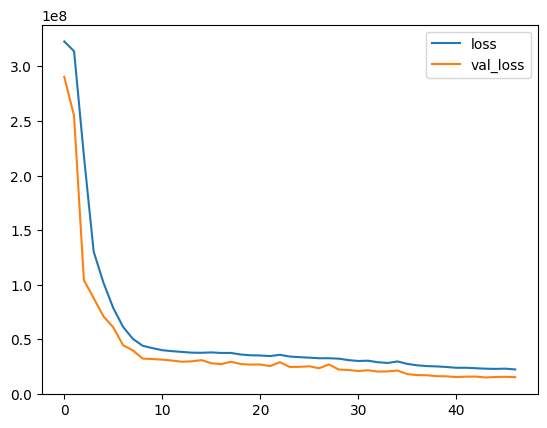

7/7 [==============================] - 0s 4ms/step


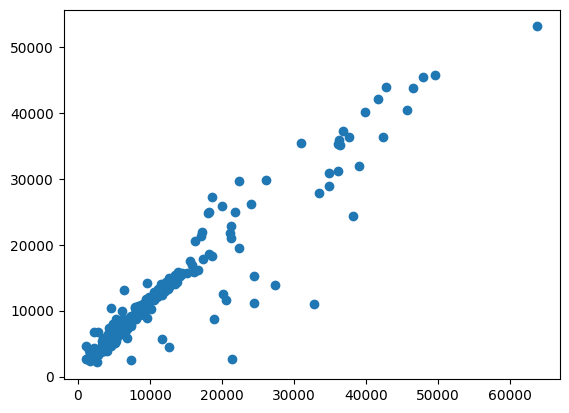

mse:  15335138.17497475


(15925677.530781338, 15335138.17497475)

In [21]:
model7 = Sequential()
model7.add(Dense(600, activation='relu'))
model7.add(Dense(600, activation='relu'))
model7.add(Dense(600, activation='relu'))
model7.add(Dense(600, activation='relu'))
model7.add(Dense(600, activation='relu'))
model7.add(Dense(1))

fit7 = model_fit(model7, optimizer='adam', batch_size=128)

mse7 = fit7['mse']

mse5, mse7

MSE decreases, so Model7 appears to be better than Model5.

## Model8: more layers under Model7

1. 6 hidden layers (600->600->600->600->600->600->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

Epoch 1/10000
8/8 [==============================] - 2s 64ms/step - loss: 322757376.0000 - val_loss: 289289760.0000
Epoch 2/10000
8/8 [==============================] - 0s 41ms/step - loss: 301534624.0000 - val_loss: 190105488.0000
Epoch 3/10000
8/8 [==============================] - 0s 42ms/step - loss: 154127696.0000 - val_loss: 95308304.0000
Epoch 4/10000
8/8 [==============================] - 0s 45ms/step - loss: 108450600.0000 - val_loss: 73800656.0000
Epoch 5/10000
8/8 [==============================] - 0s 63ms/step - loss: 78121432.0000 - val_loss: 56673032.0000
Epoch 6/10000
8/8 [==============================] - 1s 73ms/step - loss: 57642360.0000 - val_loss: 40571840.0000
Epoch 7/10000
8/8 [==============================] - 1s 67ms/step - loss: 46520056.0000 - val_loss: 35678244.0000
Epoch 8/10000
8/8 [==============================] - 1s 74ms/step - loss: 42276432.0000 - val_loss: 32519076.0000
Epoch 9/10000
8/8 [==============================] - 0s 56ms/step - loss: 41339512

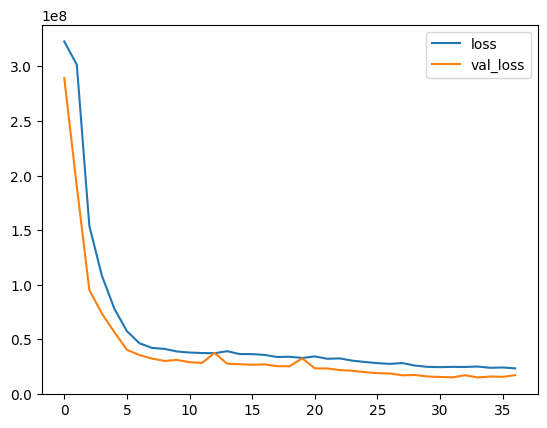

7/7 [==============================] - 0s 6ms/step


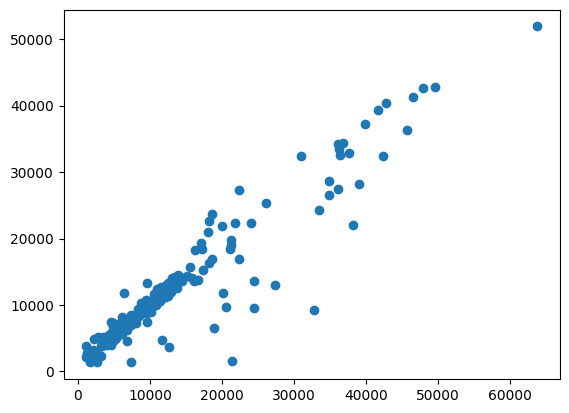

mse:  17350348.864402678


(15335138.17497475, 17350348.864402678)

In [22]:
model8 = Sequential()
model8.add(Dense(600, activation='relu'))
model8.add(Dense(600, activation='relu'))
model8.add(Dense(600, activation='relu'))
model8.add(Dense(600, activation='relu'))
model8.add(Dense(600, activation='relu'))
model8.add(Dense(600, activation='relu'))
model8.add(Dense(1))

fit8 = model_fit(model8, optimizer='adam', batch_size=128)

mse8 = fit8['mse']

mse7, mse8

Having larger MSE than Model7, try more different hyperparameter but using the same number of layers of Model7

## Model9: more neurons under Model7

1. 6 hidden layers (800->800->800->800->800->800->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

Epoch 1/10000
8/8 [==============================] - 3s 146ms/step - loss: 322296864.0000 - val_loss: 283349920.0000
Epoch 2/10000
8/8 [==============================] - 1s 72ms/step - loss: 252918992.0000 - val_loss: 123665376.0000
Epoch 3/10000
8/8 [==============================] - 1s 68ms/step - loss: 125867592.0000 - val_loss: 104316136.0000
Epoch 4/10000
8/8 [==============================] - 1s 67ms/step - loss: 102717416.0000 - val_loss: 77373288.0000
Epoch 5/10000
8/8 [==============================] - 1s 66ms/step - loss: 64832696.0000 - val_loss: 45420372.0000
Epoch 6/10000
8/8 [==============================] - 1s 66ms/step - loss: 50002764.0000 - val_loss: 41445448.0000
Epoch 7/10000
8/8 [==============================] - 1s 65ms/step - loss: 43915624.0000 - val_loss: 32429616.0000
Epoch 8/10000
8/8 [==============================] - 1s 70ms/step - loss: 41328312.0000 - val_loss: 31907068.0000
Epoch 9/10000
8/8 [==============================] - 1s 66ms/step - loss: 397192

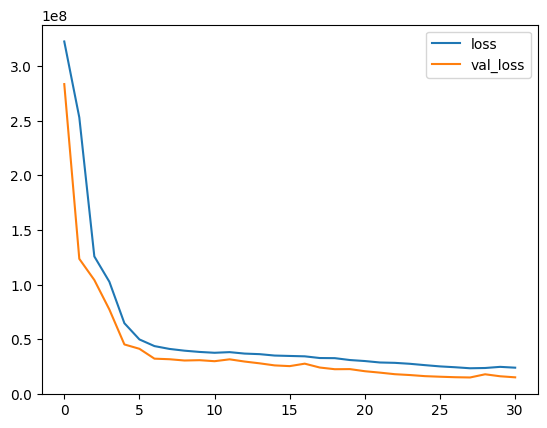

7/7 [==============================] - 0s 7ms/step


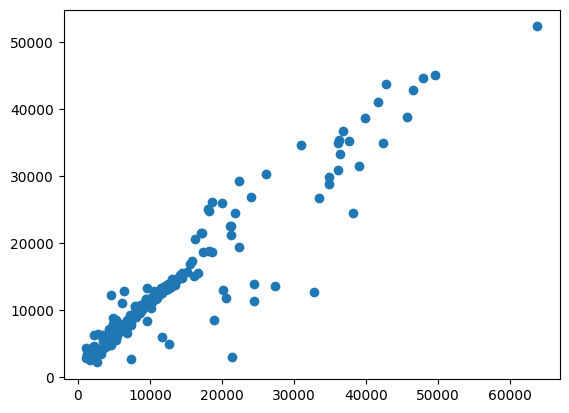

mse:  15368117.724796627


(15335138.17497475, 15368117.724796627)

In [23]:
model9 = Sequential()
model9.add(Dense(800, activation='relu'))
model9.add(Dense(800, activation='relu'))
model9.add(Dense(800, activation='relu'))
model9.add(Dense(800, activation='relu'))
model9.add(Dense(800, activation='relu'))
model9.add(Dense(800, activation='relu'))
model9.add(Dense(1))

fit9 = model_fit(model9, optimizer='adam', batch_size=128)

mse9 = fit9['mse']

mse7, mse9

Still increase in MSE, try one more different config

## Model10: using different number of neurons (higher for the first 3 layers) per layer under Model7

1. 6 hidden layers (800->800->800->600->600->600->1),
2. activation function = relu
3. optimizer = adam
4. epochs=1000 (any large value is fine as early stopping mechanism helps protecting overfitting)
5. monitoring loss=mse

Epoch 1/10000
8/8 [==============================] - 2s 78ms/step - loss: 322587072.0000 - val_loss: 287455712.0000
Epoch 2/10000
8/8 [==============================] - 0s 54ms/step - loss: 282640768.0000 - val_loss: 133896832.0000
Epoch 3/10000
8/8 [==============================] - 0s 58ms/step - loss: 136678400.0000 - val_loss: 90176168.0000
Epoch 4/10000
8/8 [==============================] - 0s 55ms/step - loss: 106507480.0000 - val_loss: 64348508.0000
Epoch 5/10000
8/8 [==============================] - 0s 57ms/step - loss: 75602160.0000 - val_loss: 49582864.0000
Epoch 6/10000
8/8 [==============================] - 0s 58ms/step - loss: 57604144.0000 - val_loss: 45009720.0000
Epoch 7/10000
8/8 [==============================] - 0s 58ms/step - loss: 47077508.0000 - val_loss: 34038656.0000
Epoch 8/10000
8/8 [==============================] - 0s 53ms/step - loss: 42733352.0000 - val_loss: 43264956.0000
Epoch 9/10000
8/8 [==============================] - 0s 53ms/step - loss: 41277412

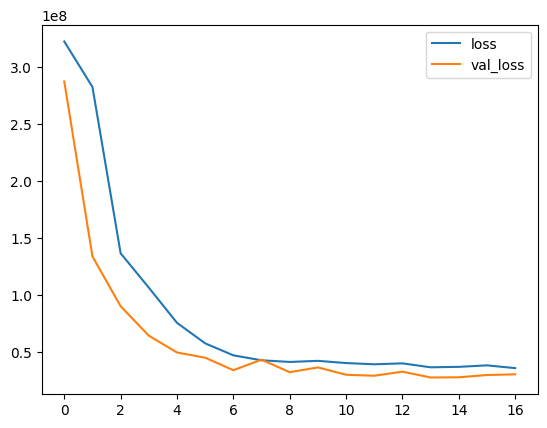

7/7 [==============================] - 0s 7ms/step


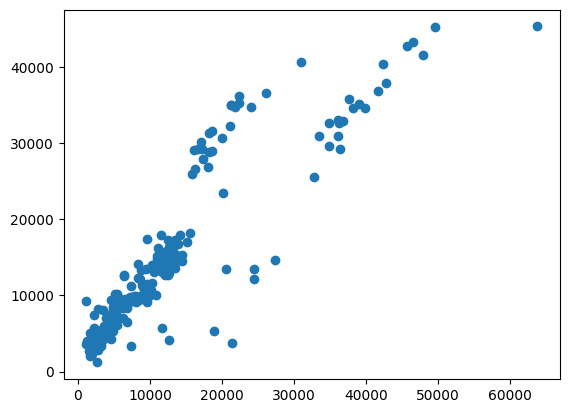

mse:  30394429.88389729


(15335138.17497475, 30394429.88389729)

In [24]:
model10 = Sequential()
model10.add(Dense(800, activation='relu'))
model10.add(Dense(800, activation='relu'))
model10.add(Dense(800, activation='relu'))
model10.add(Dense(600, activation='relu'))
model10.add(Dense(600, activation='relu'))
model10.add(Dense(600, activation='relu'))
model10.add(Dense(1))

fit10 = model_fit(model10, optimizer='adam', batch_size=128)

mse10 = fit10['mse']

mse7, mse10

Still higher MSE

# Model Comparison

In [26]:
# first see all mse in the single plot
mses = pd.DataFrame(columns=['model', 'mse'])
mse_array = np.array([mse1, mse2, mse3, mse4, mse5, mse6, mse7, mse8, mse9, mse10])

for i in range(mse_array.size):
  mses.loc[i] = ['model' + str(i+1), mse_array[i]]


mses.index = range(1,mse_array.size+1)

mses

,model,mse
1,model1,3.019073e+07
2,model2,3.068749e+07
3,model3,2.915681e+07
4,model4,1.599898e+07
5,model5,1.592568e+07
6,model6,2.643735e+07
7,model7,1.533514e+07
8,model8,1.735035e+07
9,model9,1.536812e+07
10,model10,3.039443e+07


<Axes: >

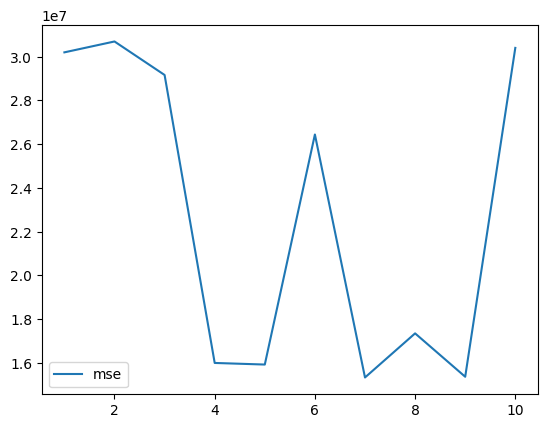

In [27]:
mses.plot()

Among all tried models, Model7 has the lowest MSE

# Model Accuracy

We will use the Model7 to test the accuracy for the unseen dataset

7/7 [==============================] - 0s 7ms/step


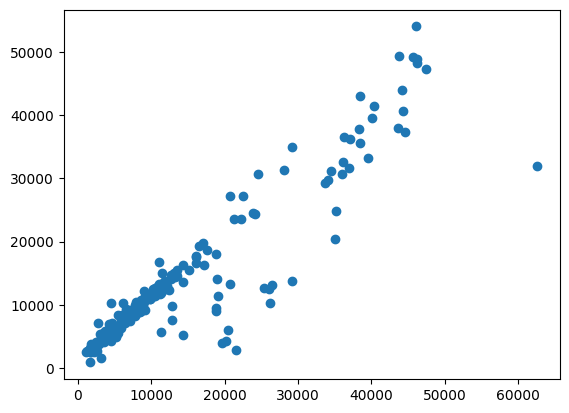

mse:  23951860.655560356


In [28]:
prediction = model7.predict(X_test)
plt.scatter(y_test, prediction)
plt.show()

# test MSE
mse = mean_squared_error(y_test, prediction)
print('mse: ', mse)


# Conclusion

In conclusion under these trials, we find that using Model6 will have the smallest MSE among the rest.

For further trials, we can try using more different activation functions; different optimizer; more (or less) patience for early stopping;

# Final Model

In [29]:
model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 600)               5400      
                                                                 
 dense_33 (Dense)            (None, 600)               360600    
                                                                 
 dense_34 (Dense)            (None, 600)               360600    
                                                                 
 dense_35 (Dense)            (None, 600)               360600    
                                                                 
 dense_36 (Dense)            (None, 600)               360600    
                                                                 
 dense_37 (Dense)            (None, 1)                 601       
                                                                 
Total params: 1448401 (5.53 MB)
Trainable params: 1448

In [30]:
# MSE for the test dataset
mse

23951860.655560356

In [ ]:
# mse for the linear regression in another project

2.378636e+07

23786360.0

# Remarks

## Building the Neural Network

We've set seed for the train test split dataset, however, the network itself has its own randomization of the initial state, although we can "somehow" reproduce the result, but it required much more configuration to set the seed including the global seed and operation level seed.

Alhough it is possible that the model I chose maybe different from the other trial, the difference is insignificance. From my testing, each time which Model attains the minimum maybe different, but most likely are using Model5 to Model8


## Neural Network vs Linear Regression

Compared to Linear Regression in another notebook, the MSE for the test dataset is 23951860.655560356, which is smaller than that of this neural network model.

The use of Neural Network is easier to use as we simply needed to perform trial and error for different models; for Linear Regression, we need more statistical knowledge to perform modelling, especially we need to have knowledge of statistical inference including likelihood, significance test, p-value, etc...

Also, for interpretability, using Linear Regression is easier to interpret than neural network, as linear regression is using the linear combination of predictors to estimate the mean response; while neural network is a so-called black box model, we cannot easily interpret the model.

However, linear regression and different statistical models have their own assumptions. For neural network, we seldomly required to have high attention.

So in general, if it is possible, try first using Linear Regression. If difficult (or some assumptions failed clearly), then use Neural Network instead

In [31]:
# mse of neural network model 6 vs linear regression

mse > 23786360.0

True